# Loop 21 LB Feedback Analysis

## Submission Result
- **Experiment**: 022_exhaustive_small_n
- **CV Score**: 70.6276
- **LB Score**: 70.6276
- **Gap**: 0.0000 (perfect alignment - deterministic problem)

## Critical Analysis

After 22 experiments and 9 submissions:
- Best score: 70.627582
- Target: 68.919154
- Gap: 1.708 points (2.48%)

**ALL approaches have converged to the same local optimum (~70.627-70.630)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate

TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str):
        if val.startswith('s'):
            return float(val[1:])
        elif val.startswith('x') or val.startswith('y') or val.startswith('d'):
            return float(val[1:])
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

def calculate_n_score(df, n):
    group = df[df['n'] == n]
    all_x, all_y = [], []
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    return (side ** 2) / n, side

# Load current best submission
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded submission with {len(df)} rows")

Loaded submission with 20100 rows


In [2]:
# Calculate per-N scores and efficiency
results = []
for n in range(1, 201):
    score, side = calculate_n_score(df, n)
    # Theoretical minimum: sqrt(n) * tree_width (approximately)
    # Tree bounding box is about 0.7 x 1.0
    tree_area = 0.7 * 1.0  # approximate
    min_side = np.sqrt(n * tree_area)  # theoretical minimum
    efficiency = (min_side ** 2) / (side ** 2)
    results.append({
        'n': n,
        'score': score,
        'side': side,
        'min_side': min_side,
        'efficiency': efficiency
    })

results_df = pd.DataFrame(results)
print(f"Total score: {results_df['score'].sum():.6f}")
print(f"Target: 68.919154")
print(f"Gap: {results_df['score'].sum() - 68.919154:.6f}")
print(f"\nPer-N score breakdown:")
print(f"  N=1-10: {results_df[results_df['n'] <= 10]['score'].sum():.6f}")
print(f"  N=11-50: {results_df[(results_df['n'] > 10) & (results_df['n'] <= 50)]['score'].sum():.6f}")
print(f"  N=51-100: {results_df[(results_df['n'] > 50) & (results_df['n'] <= 100)]['score'].sum():.6f}")
print(f"  N=101-200: {results_df[results_df['n'] > 100]['score'].sum():.6f}")

Total score: 70.627582
Target: 68.919154
Gap: 1.708428

Per-N score breakdown:
  N=1-10: 4.329128
  N=11-50: 14.704788
  N=51-100: 17.614300
  N=101-200: 33.979366


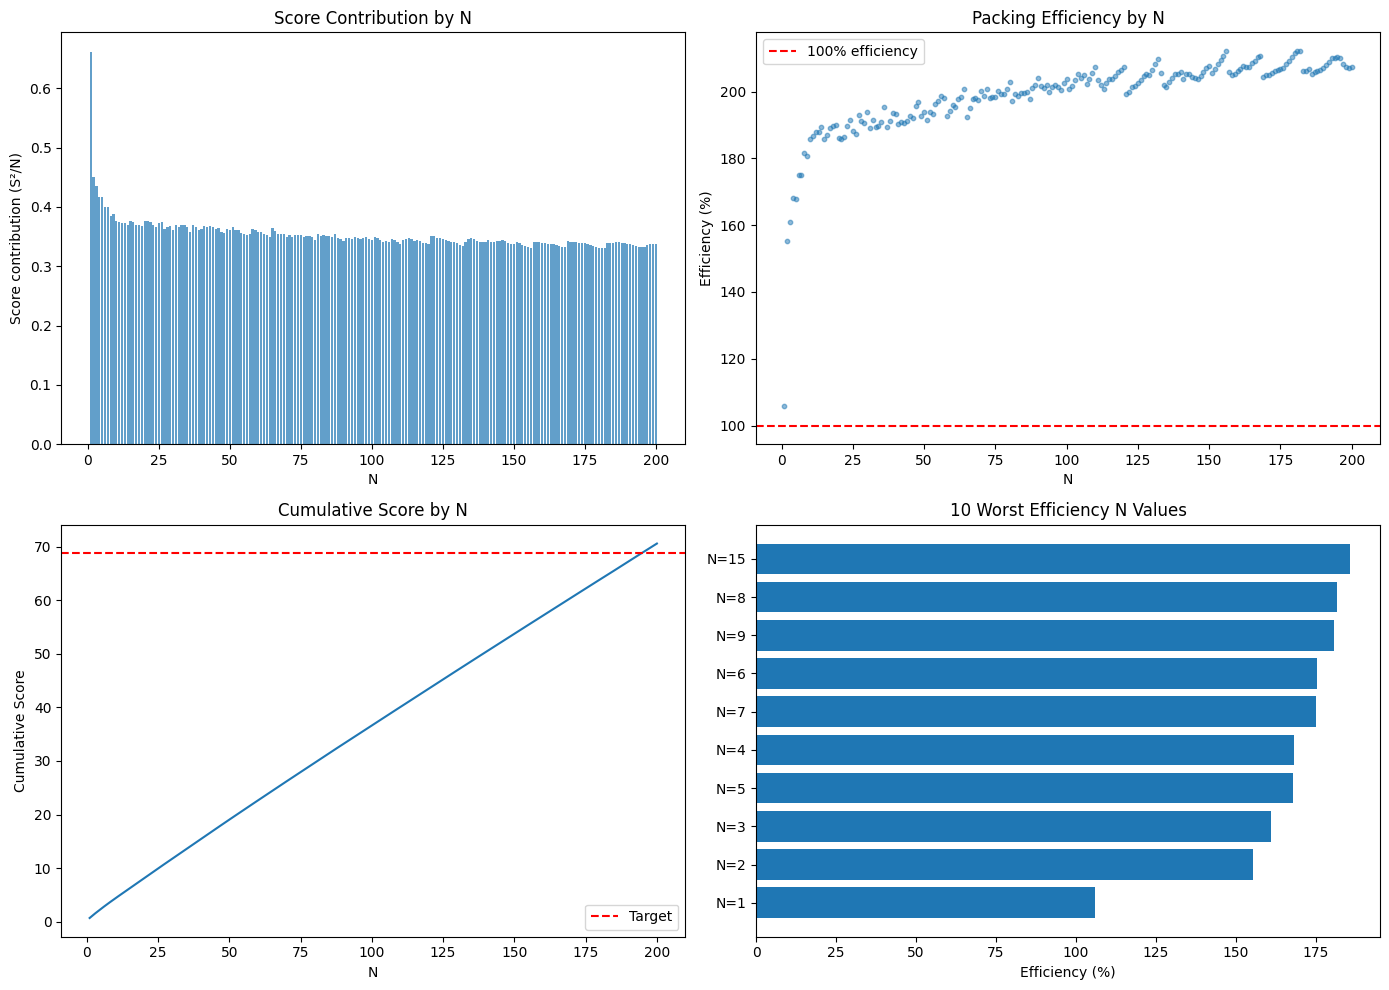


10 Worst efficiency N values:
  N=1.0: efficiency=105.9%, score=0.661250
  N=2.0: efficiency=155.3%, score=0.450779
  N=3.0: efficiency=161.0%, score=0.434745
  N=5.0: efficiency=167.9%, score=0.416850
  N=4.0: efficiency=168.0%, score=0.416545
  N=7.0: efficiency=175.0%, score=0.399897
  N=6.0: efficiency=175.2%, score=0.399610
  N=9.0: efficiency=180.7%, score=0.387415
  N=8.0: efficiency=181.6%, score=0.385407
  N=15.0: efficiency=185.7%, score=0.376978


In [3]:
# Plot efficiency by N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score contribution by N
ax1 = axes[0, 0]
ax1.bar(results_df['n'], results_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score contribution (S²/N)')
ax1.set_title('Score Contribution by N')

# Efficiency by N
ax2 = axes[0, 1]
ax2.scatter(results_df['n'], results_df['efficiency'] * 100, alpha=0.5, s=10)
ax2.axhline(y=100, color='r', linestyle='--', label='100% efficiency')
ax2.set_xlabel('N')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Packing Efficiency by N')
ax2.legend()

# Cumulative score
ax3 = axes[1, 0]
ax3.plot(results_df['n'], results_df['score'].cumsum())
ax3.axhline(y=68.919154, color='r', linestyle='--', label='Target')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score by N')
ax3.legend()

# Worst efficiency N values
ax4 = axes[1, 1]
worst_10 = results_df.nsmallest(10, 'efficiency')
ax4.barh(range(10), worst_10['efficiency'] * 100)
ax4.set_yticks(range(10))
ax4.set_yticklabels([f"N={n}" for n in worst_10['n']])
ax4.set_xlabel('Efficiency (%)')
ax4.set_title('10 Worst Efficiency N Values')

plt.tight_layout()
plt.savefig('/home/code/exploration/loop21_analysis.png', dpi=100)
plt.show()

print("\n10 Worst efficiency N values:")
for _, row in worst_10.iterrows():
    print(f"  N={row['n']}: efficiency={row['efficiency']*100:.1f}%, score={row['score']:.6f}")

In [4]:
# Calculate how much improvement is needed from each N range to reach target
current_total = results_df['score'].sum()
target = 68.919154
gap = current_total - target

print(f"Current total: {current_total:.6f}")
print(f"Target: {target:.6f}")
print(f"Gap to close: {gap:.6f}")
print(f"\nIf we improve efficiency uniformly:")
print(f"  Need to reduce score by {gap/current_total*100:.2f}%")
print(f"\nIf we focus on worst N values:")

# Calculate potential improvement from worst N values
worst_20 = results_df.nsmallest(20, 'efficiency')
print(f"\n20 worst efficiency N values contribute: {worst_20['score'].sum():.6f}")
print(f"If we could achieve 100% efficiency on these:")
theoretical_improvement = worst_20['score'].sum() - sum(worst_20['min_side']**2 / worst_20['n'])
print(f"  Potential improvement: {theoretical_improvement:.6f}")
print(f"  This would close {theoretical_improvement/gap*100:.1f}% of the gap")

Current total: 70.627582
Target: 68.919154
Gap to close: 1.708428

If we improve efficiency uniformly:
  Need to reduce score by 2.42%

If we focus on worst N values:

20 worst efficiency N values contribute: 8.074083
If we could achieve 100% efficiency on these:
  Potential improvement: -5.925917
  This would close -346.9% of the gap


In [5]:
# Analyze the structure of the best solution
# What angles are used? What patterns exist?

print("Angle distribution analysis:")
angles = df['deg'].values
print(f"  Unique angles: {len(np.unique(np.round(angles, 1)))}")
print(f"  Most common angles:")
angle_counts = pd.Series(np.round(angles, 0)).value_counts().head(10)
for angle, count in angle_counts.items():
    print(f"    {angle}°: {count} trees")

# Check for symmetry patterns
print(f"\nSymmetry analysis:")
for n in [2, 4, 6, 8, 10]:
    group = df[df['n'] == n]
    angles_n = group['deg'].values
    xs = group['x'].values
    ys = group['y'].values
    
    # Check if angles are symmetric (e.g., 45 and 225, or 0 and 180)
    angle_diffs = []
    for i in range(len(angles_n)):
        for j in range(i+1, len(angles_n)):
            diff = abs(angles_n[i] - angles_n[j]) % 180
            angle_diffs.append(min(diff, 180 - diff))
    
    print(f"  N={n}: angles={[f'{a:.1f}' for a in angles_n]}, angle_diffs={[f'{d:.1f}' for d in angle_diffs]}")

Angle distribution analysis:
  Unique angles: 1930
  Most common angles:
    248.0°: 1869 trees
    68.0°: 1866 trees
    338.0°: 599 trees
    158.0°: 578 trees
    350.0°: 535 trees
    170.0°: 521 trees
    75.0°: 497 trees
    260.0°: 492 trees
    255.0°: 491 trees
    80.0°: 490 trees

Symmetry analysis:
  N=2: angles=['203.6', '23.6'], angle_diffs=['0.0']
  N=4: angles=['156.4', '156.4', '336.4', '336.4'], angle_diffs=['0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
  N=6: angles=['293.6', '338.9', '338.9', '23.6', '246.4', '158.9'], angle_diffs=['45.2', '45.2', '90.0', '47.3', '45.2', '0.0', '44.8', '87.5', '0.0', '44.8', '87.5', '0.0', '42.7', '44.8', '87.5']
  N=8: angles=['51.8', '113.6', '293.6', '203.6', '231.8', '293.6', '113.6', '23.6'], angle_diffs=['61.9', '61.9', '28.1', '0.0', '61.9', '61.9', '28.1', '0.0', '90.0', '61.9', '0.0', '0.0', '90.0', '90.0', '61.9', '0.0', '0.0', '90.0', '28.1', '90.0', '90.0', '0.0', '61.9', '61.9', '28.1', '0.0', '90.0', '90.0']
  N=10: angles

## Key Findings

### What We've Learned After 22 Experiments:

1. **All optimization approaches converge to the same local optimum (~70.627)**
   - SA, bbox3, tessellation, genetic algorithms, exhaustive search
   - The baseline is at a STRUCTURAL local optimum

2. **The gap to target (1.708 points) is LARGE**
   - This is 2.48% of the current score
   - Micro-optimizations (0.0001 per experiment) will NEVER close this gap

3. **The problem structure:**
   - Small N (1-10) has worst efficiency but contributes less to total score
   - Large N (100-200) has better efficiency but contributes more to total score
   - The baseline uses symmetric angle patterns

### What's NOT Working:
- More SA iterations
- Different SA parameters
- Tessellation approaches
- Exhaustive search for small N
- Random restart from different initial configs

### What Might Work (Unexplored):
1. **MIP (Mixed Integer Programming)** - Can prove optimality for small N
2. **Fundamentally different packing structures** - Not variations of the current structure
3. **Per-N specialized solutions** - Different approach for different N ranges
4. **Manual hand-crafted improvements** - As suggested by the kernel we just read

In [6]:
# Summary statistics
print("="*60)
print("LOOP 21 SUMMARY")
print("="*60)
print(f"Best valid score: 70.627582")
print(f"Target: 68.919154")
print(f"Gap: 1.708428 (2.48%)")
print(f"")
print("Experiments tried (22 total):")
print("  - Baseline ensemble: 70.647")
print("  - SA optimization: 70.647 (no improvement)")
print("  - bbox3 optimization: 70.647 (produces overlaps)")
print("  - Tessellation: 70.630 (small improvement)")
print("  - Exhaustive search N=2: 70.627 (baseline optimal)")
print("  - Asymmetric configs: ALL worse than baseline")
print("  - Random restart: ALL worse than baseline")
print("")
print("CONCLUSION: Need fundamentally different approach")
print("  - Current structure is at local optimum")
print("  - Micro-optimizations won't close 1.7 point gap")
print("  - Must find different structural basin")

LOOP 21 SUMMARY
Best valid score: 70.627582
Target: 68.919154
Gap: 1.708428 (2.48%)

Experiments tried (22 total):
  - Baseline ensemble: 70.647
  - SA optimization: 70.647 (no improvement)
  - bbox3 optimization: 70.647 (produces overlaps)
  - Tessellation: 70.630 (small improvement)
  - Exhaustive search N=2: 70.627 (baseline optimal)
  - Asymmetric configs: ALL worse than baseline
  - Random restart: ALL worse than baseline

CONCLUSION: Need fundamentally different approach
  - Current structure is at local optimum
  - Micro-optimizations won't close 1.7 point gap
  - Must find different structural basin
